# Projeto 6 - Classificação multiclasse Iris

## 1. Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
torch.__version__

'2.5.0'

In [2]:
torch.set_default_device("mps")
device = torch.device("mps")

# torch.set_default_device("cpu")
# device = torch.device("cpu")

In [3]:
print(torch.backends.mps.is_available())  # Deve retornar True
print(torch.backends.mps.is_built())  # Deve retornar True

True
True


## 2. Importando dados

In [4]:
np.random.seed(123)
torch.manual_seed(123)

In [5]:
base = pd.read_csv('data/iris.csv')

In [6]:
base.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<Axes: xlabel='count', ylabel='class'>

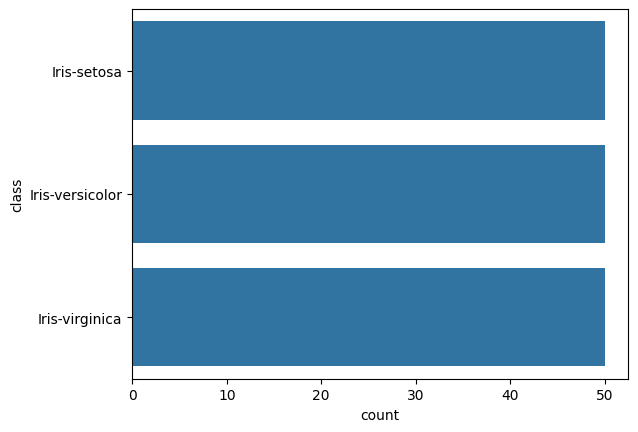

In [7]:
sns.countplot(base['class'])

In [8]:
previsores = base.drop(columns=['class']).copy()
classe = base['class'].copy()

In [9]:
previsores

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [10]:
classe

0         Iris-setosa
1         Iris-setosa
2         Iris-setosa
3         Iris-setosa
4         Iris-setosa
            ...      
145    Iris-virginica
146    Iris-virginica
147    Iris-virginica
148    Iris-virginica
149    Iris-virginica
Name: class, Length: 150, dtype: object

In [11]:
classe.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [12]:
encoder = LabelEncoder()
classe = encoder.fit_transform(classe)

In [13]:
np.unique(classe)

array([0, 1, 2])

In [14]:
previsores_treino, previsores_teste, classe_treino, classe_teste = train_test_split(previsores,
                                                                                   classe,
                                                                                   test_size=0.25)

In [15]:
previsores_treino.shape

(112, 4)

In [16]:
type(previsores_treino)

pandas.core.frame.DataFrame

In [18]:
previsores_treino = torch.tensor(np.array(previsores_treino), dtype=torch.float)
classe_treino = torch.tensor(np.array(classe_treino), dtype=torch.long)

In [19]:
classe_treino

tensor([0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 2,
        1, 0, 0, 2, 1, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0,
        0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1,
        1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2,
        2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2], device='mps:0')

## 3. Construção do modelo

In [21]:
# 4 -> 4-> 4-> 3
# (entrada + saidas) / 2 = (4 + 3) / 2

classificador = nn.Sequential(
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 3)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classificador.parameters(),
                       lr = 0.001,
                       weight_decay = 0.001)

In [23]:
dataset = torch.utils.data.TensorDataset(previsores_treino, classe_treino)
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=10, 
                                           shuffle=True, 
                                           pin_memory=False,  # MPS não suporta pin_memory=True
                                           generator=torch.Generator(device=device))

## 4. Treinamento do modelo

In [26]:
for epoch in range(100):
    running_loss = 0.
    running_accuracy = 0.

    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = classificador.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        outputs = F.softmax(outputs)
        top_p, top_class = outputs.topk(k=1, dim=1) # k=1 -> maior valor, dim=1 -> retorna a classe

        equals = top_class == labels.view(*top_class.shape) # Retorna True ou False -> comparativo entre predito e real

        running_accuracy += torch.mean(equals.type(torch.float))

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch + 1}, loss: {running_loss/len(train_loader)}, accuracy: {running_accuracy/len(train_loader)}")

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


Epoch: 1, loss: 1.1263112376133602, accuracy: 0.3333333432674408
Epoch: 2, loss: 1.1089561680952709, accuracy: 0.3333333432674408
Epoch: 3, loss: 1.1136474708716075, accuracy: 0.3333333432674408
Epoch: 4, loss: 1.086080809434255, accuracy: 0.3333333432674408
Epoch: 5, loss: 1.0726759632428486, accuracy: 0.3333333432674408
Epoch: 6, loss: 1.077180340886116, accuracy: 0.30000001192092896
Epoch: 7, loss: 1.0502939025561016, accuracy: 0.3333333432674408
Epoch: 8, loss: 1.0587223867575328, accuracy: 0.3333333432674408
Epoch: 9, loss: 1.0703606456518173, accuracy: 0.2916666865348816
Epoch: 10, loss: 1.0458408494790394, accuracy: 0.2916666865348816
Epoch: 11, loss: 1.0257234175999959, accuracy: 0.4000000059604645
Epoch: 12, loss: 1.019995187719663, accuracy: 0.4583333432674408
Epoch: 13, loss: 1.013313298424085, accuracy: 0.4000000059604645
Epoch: 14, loss: 1.029752125342687, accuracy: 0.3500000238418579
Epoch: 15, loss: 0.9947399745384852, accuracy: 0.42500004172325134
Epoch: 16, loss: 0.997

## 5. Avaliação do modelo

In [27]:
classificador.eval()

Sequential(
  (0): Linear(in_features=4, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=3, bias=True)
)

In [29]:
type(previsores_teste)

pandas.core.frame.DataFrame

In [30]:
previsores_teste = torch.tensor(np.array(previsores_teste), dtype=torch.float)

In [31]:
previsoes = classificador(previsores_teste)
previsoes

tensor([[-6.0684,  1.7581,  2.0304],
        [-8.1622,  1.9086,  3.6956],
        [-9.0335,  1.8574,  4.5773],
        [-3.0387,  1.5654, -0.3528],
        [ 4.9045,  1.1689, -6.7585],
        [-5.9240,  1.7040,  2.0287],
        [-4.9176,  1.6764,  1.1104],
        [ 4.8401,  1.1438, -6.6681],
        [ 4.6314,  1.0773, -6.3569],
        [-3.9881,  1.5926,  0.4457],
        [-7.9403,  1.8434,  3.6087],
        [ 5.8160,  1.4254, -7.9121],
        [-3.5781,  1.4578,  0.3177],
        [-7.1600,  1.8902,  2.8216],
        [-9.8992,  2.1160,  4.8983],
        [-9.0045,  1.9143,  4.4618],
        [ 5.2775,  1.2629, -7.1724],
        [ 4.7190,  1.1125, -6.5397],
        [-4.6215,  1.7228,  0.8002],
        [ 4.5998,  1.0909, -6.4152],
        [ 5.1495,  1.2280, -7.0189],
        [-5.8456,  1.8065,  1.7612],
        [ 4.9962,  1.2144, -6.9580],
        [-6.1016,  1.7343,  2.1357],
        [ 5.4678,  1.3197, -7.4309],
        [ 5.0178,  1.2350, -7.0479],
        [ 4.8591,  1.1850, -6.8283],
 

In [32]:
F.softmax(previsoes)

/Users/michelarruda/miniconda3/envs/deep-learning-deAaZ-Pytorch/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


tensor([[1.7248e-04, 4.3225e-01, 5.6757e-01],
        [6.0669e-06, 1.4343e-01, 8.5656e-01],
        [1.1513e-06, 6.1807e-02, 9.3819e-01],
        [8.6527e-03, 8.6440e-01, 1.2694e-01],
        [9.7669e-01, 2.3301e-02, 8.4052e-06],
        [2.0411e-04, 4.1944e-01, 5.8036e-01],
        [8.7223e-04, 6.3728e-01, 3.6185e-01],
        [9.7578e-01, 2.4215e-02, 9.8041e-06],
        [9.7217e-01, 2.7811e-02, 1.6429e-05],
        [2.8531e-03, 7.5678e-01, 2.4037e-01],
        [8.2365e-06, 1.4613e-01, 8.5386e-01],
        [9.8776e-01, 1.2241e-02, 1.0779e-06],
        [4.9010e-03, 7.5400e-01, 2.4110e-01],
        [3.3173e-05, 2.8262e-01, 7.1735e-01],
        [3.5273e-07, 5.8285e-02, 9.4171e-01],
        [1.3150e-06, 7.2588e-02, 9.2741e-01],
        [9.8226e-01, 1.7731e-02, 3.8488e-06],
        [9.7356e-01, 2.6428e-02, 1.2554e-05],
        [1.2555e-03, 7.1469e-01, 2.8406e-01],
        [9.7093e-01, 2.9058e-02, 1.5974e-05],
        [9.8057e-01, 1.9426e-02, 5.0907e-06],
        [2.4285e-04, 5.1120e-01, 4

In [34]:
previsoes = [np.argmax(t) for t in previsoes.detach().cpu().numpy()]

In [35]:
previsoes

[np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(2),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(2),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(2),
 np.int64(0)]

In [37]:
matriz = confusion_matrix(previsoes, classe_teste)

<Axes: >

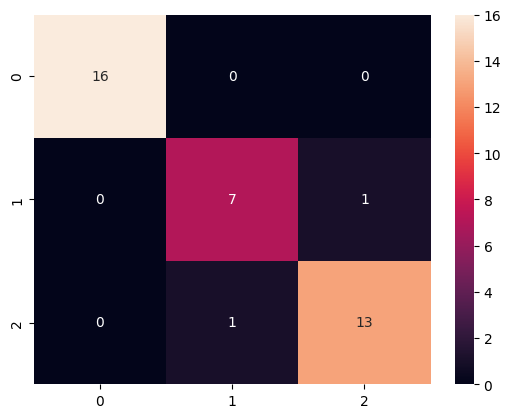

In [38]:
sns.heatmap(matriz, annot=True)